# SpaceRocks

### Vectorized coordinate transformation and ephemeris calculation with robust unit handling.

To install, simply `pip install spacerocks`

In [2]:
from spacerocks import SpaceRock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

You can also pass in just a single object or an array of objects. I'll try BP519. Here I've turned on precision. This involves a non-vectorized solution to Kepler's equation to calculate the eccentric anomaly, and a topocentric correction to the Earth's position. Right now, only DECam is supported, but I'm working on implementing an obscode feature.

In [23]:
df = pd.read_json('/Users/kjnapier/Desktop/mpcorb_extended.json')
df = df[df.a * (1 - df.e) >= 38]
#df = df[df.Orbit_type == 'Jupiter Trojan']
#df = df[df.Num_opps > 2]

In [24]:
rocks = SpaceRock(a=df.a.values, 
                  e=df.e.values, 
                  inc=df.i.values, 
                  arg=df.Peri.values, 
                  node=df.Node.values, 
                  epoch=df.Tp.values, 
                  tau=df.Epoch.values,
                  H=df.H.values, 
                  name=df.Principal_desig.values.astype(str),
                  precise=False,
                  input_coordinates='keplerian',
                  input_frame='heliocentric',
                  input_angles='degrees',
                  obscode=None)

/usr/local/bin/anaconda/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/bin/anaconda/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in arccos
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/bin/anaconda/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [10]:
eta0 = np.sqrt(1 - rocks.e**2) * np.cos(rocks.inc)
eta0_TNOs = np.sqrt(1 - TNOs.e**2) * np.cos(TNOs.inc)

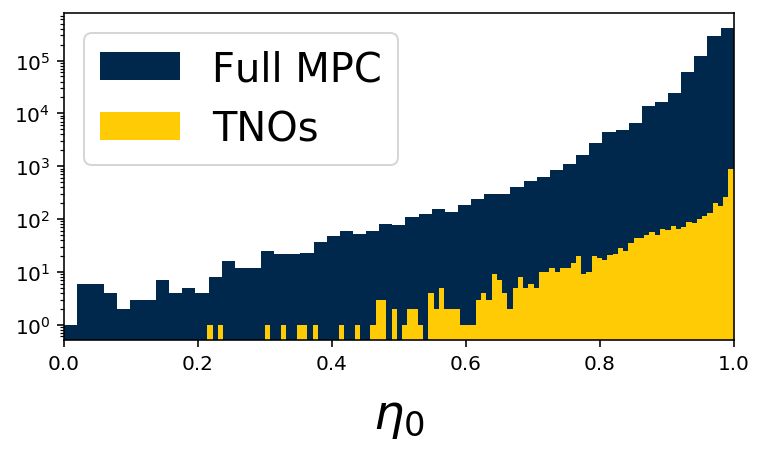

In [18]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = ax.hist(eta0.value, bins=100, color='#00274C', label='Full MPC')
_ = ax.hist(eta0_TNOs.value, bins=100, color='#FFCB05', label='TNOs')
ax.set_yscale('log', nonposy='clip')
ax.set_xlim([0, 1])
ax.set_xlabel(r'$\eta_0$', fontsize=24, labelpad=10)
ax.legend(fontsize=20);

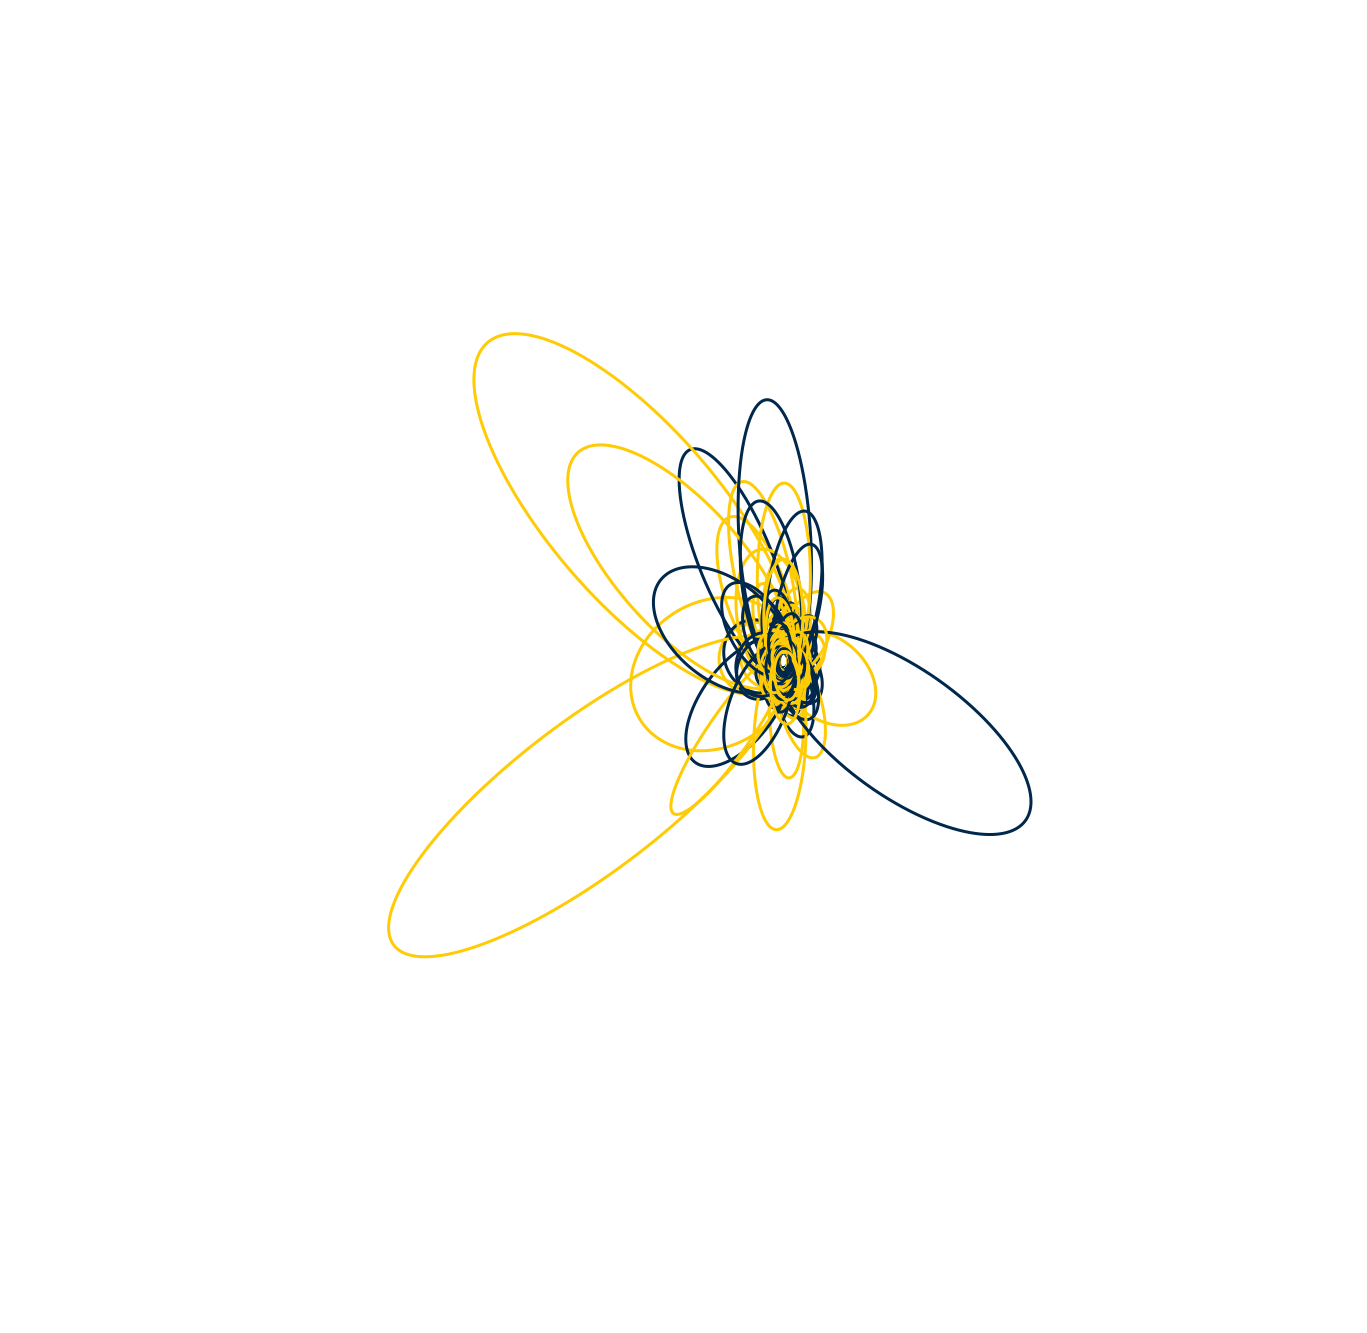

In [13]:
fig, ax = rocks.plot_orbits()

In [17]:
fig.savefig('/Users/kjnapier/Desktop/AllTNOs.pdf', format='pdf')

In [4]:
BP = SpaceRock(a=4.487673062316562E+02, 
               e=9.214543710796702E-01, 
               inc=5.411068217470999E+01, 
               arg=3.480587931444684E+02, 
               node=1.352131434907198E+02, 
               epoch=2.473015776611103E+06, 
               tau=2458982.5,
               H=4.5, 
               name='BP',
               precise=True,
               input_coordinates='keplerian',
               input_frame='barycentric',
               input_angles='degrees',
               obscode=304)